<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻🚙 01 - Visual Lane Following

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/pic1_rect.png", width=400px>
  <figcaption>The view from a Duckiebot when centered in its lane.</figcaption>
  </div>
</figure>

We have explored different image processing algorithms as a means of enhancing certain aspects of an image (e.g., edges), while diminishing the presence of others (e.g., noise, irrelevant texture, etc.). We have implemented some of these tools to perform a Braitenberg-like approach to visual servoing, whereby we use weightings over edge detections to control the Duckiebot's steering in an effort to keep it in its lane as it drives forward.

The previous approach was *state-less*---it reacted to the robot's image, but had no (explicit) representation of the state of the robot or the environment. Rather than design a controller that reasons over the raw image, we will process the image to estimate the robot's orientation (heading) relative to the lane. We can then combine this estimate for the robot's lane-relative heading with the PID controller that we developed earlier to in an effort to keep the robot in its lane.

In the following, we will investigate one approach to estimating the robot's lane-relative orientation from images. Similar to the previous exercise, this approach makes use of the dashed-yellow and solid-white lane markings as valuable cues for determining the robot's orientation relative to the lane. The key is to isolate these lane markings from the rest of the image and then approximate them as a set of line segments. We can then transform these line segments into the ground reference frame and then determine the best-fit to their orientations relative to the robot. We can then estimate the orientation of the robot relative to the lane.

In [1]:
## Run this cell to import relevant modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

from matplotlib import pyplot as plt
import numpy as np
import cv2

Populating the interactive namespace from numpy and matplotlib


Let's load the image into Python and then generate HSV and grayscale versions for use later. 

**Note**: We provide several other images that you can experiment with as well, including one from the Duckiebot entering a turn as well as one from the simulator. As you explore this exercise, we encourage you to experiment with some of these other images by uncommenting them below. When you do, make sure to use the correct homography below.

In [12]:
# Load in the image and generate hsv and grayscale versions
image = cv2.imread('../images/visual_control/pic11.png')

# Feel free to also experiment with some of these other images
#image = cv2.imread('../images/visual_control/turn.png')
#image = cv2.imread('../images/visual_control/pic10.png')
#image = cv2.imread('../images/visual_control/pic11.png')
#image = cv2.imread('../images/visual_control/pic12.png')
#image = cv2.imread('../images/visual_control/pic1_rect.png')
#image = cv2.imread('../images/visual_control/pic2_rect.png')
#image = cv2.imread('../images/visual_control/pic3_rect.png')
#image = cv2.imread('../images/visual_control/simulation.png')

# OpenCV uses BGR by default, whereas matplotlib uses RGB, so we generate an RGB version for the sake of visualization
imgrgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to HSV for any color-based filtering
imghsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Most of our operations will be performed on the grayscale version
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

Load the homography associated with this image, which defines the transformation from coordinates in the planar ground reference frame to the image frame.

*Note*: We provide both the homography for the Duckiebot that acquired the real images as well as the one for the simulated image that you can load above. As you experiment with the different images, make sure that you are loading the correct homography.

*Note*: For the exercises that you run in simulation and on a physical robot, the robot will use its own homography (the one that you calibrated in the case of the physical robot).

In [13]:
# The image-to-ground homography associated with this image
H = np.array([-4.137917960301845e-05, -0.00011445854191468058, -0.1595567007347241, 
              0.0008382870319844166, -4.141689222457687e-05, -0.2518201638170328, 
              -0.00023561657746150284, -0.005370140574116084, 0.9999999999999999])

# The image-to-ground homography associated with the simulator
#H = np.array([3.6786120821220206e-05, -0.0003020442956870102, -0.22323525123759788, 
#              0.0011114100508941233, -4.027463270825093e-05, -0.34411062222090527, 
#              0.00046832025922603586, -0.008119176946450972, 0.9999999999999999])

H = np.reshape(H,(3, 3))
Hinv = np.linalg.inv(H)

## Detecting Lane Markings using the Canny Edge Detector

Lane markings appear as locations in the image marked by rapid changes in intensity. We have explored different approaches to isolating these *edges* based on intensity gradients, most recently using the Sobel Operator. A popular approach to detecting edges is the *Canny edge detector*. 

Like other edge detectors, the Canny edge detector looks for regions of the image with strong intensity gradients. The algorithm then refines these detections via non-maxima supression (a variant of which we used for the Sobel Operator-based edge detection). While non-maxmia suppression is often effective at removing edges that result from noise, it can also get rid of valid edges. Thus, the Canny edge detector employs a form of hysteresis, whereby it preserves "weak" edges that are connected to "strong" edges. Here, the idea is that valid edges that may appear as weak will be connected to strong edges, whereas those that occur as a result of noise will not be connected to strong edges.

In this way, the Canny edge detector divides edges into three groups:

1. Those whose gradient magnitude is sufficiently large that they are identified as valid edges.

2. Those whose gradient magnitude is sufficiently low that they are identified as erroneous edges.

3. Those whose gradient magnitude is inconclusive and are evaluated in terms of hysteresis.

The Canny edge detector differentiates between the three using two thresholds, a `canny_lower_threshold` below which edges are labeled as being erroneous, a `canny_upper_threshold` above which edges are labeled as being valid. Intensity gradients between the two thresholds are further evaluated in terms of hysteresis.

We will be discussing Canny edge detection in more detail later in the course, but if you are interested in more information on how the algorithm works, please see the [Canny edge detector Wikipedia page](https://en.wikipedia.org/wiki/Canny_edge_detector).

### Example: Canny Edge Detection

Like any edge detector, the Canny edge detector looks for regions of the image where there are large changes in intensity. We can reduce the extent to which noise in the image leads to candidate edges by smoothing the image with a Gaussian blurring kernel.

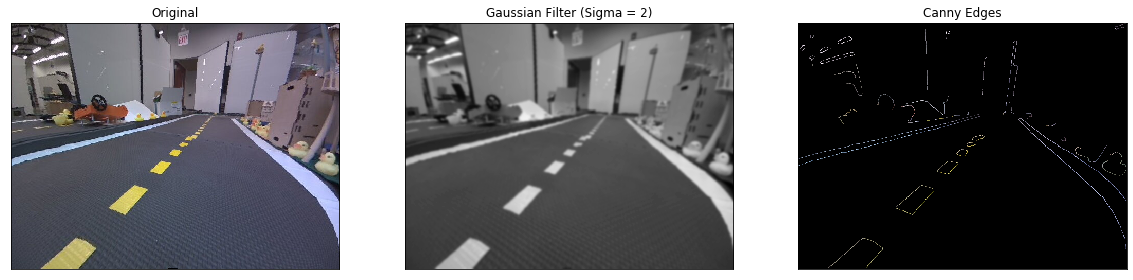

In [14]:
# TODO: Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.
sigma = 2

# Smooth the image using a Gaussian kernel
img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

canny_lower_threshold = 80
canny_upper_threshold = 200
canny_kernel_size = 3;

edges = cv2.Canny(img_gaussian_filter, canny_lower_threshold, canny_upper_threshold, canny_kernel_size)
mask_edges = (edges != 0)
dst = image * (mask_edges[:,:,None].astype(image.dtype))

# Visualize the result of Canny edge detection
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(img_gaussian_filter,cmap = 'gray')
ax2.set_title('Gaussian Filter (Sigma = ' + str(sigma) +')'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax3.set_title('Canny Edges'), ax3.set_xticks([]), ax3.set_yticks([]);

## Finding the Horizon

In Duckietown, the ground is planar and in other self-driving and robotics domains, it is often assumed that the ground is locally planar. We can exploit this as we search for lane markings by not searching above the horizon. In the world frame relative to which we estimated the homography (i.e., a reference frame with the origin centered between the drive wheels with the positive $x$-axis pointing forward and the positive $y$-axis to the left), the horizon corresponds to large $x$-coordinates. In Duckietown, we are only interested in the road a few meters in front of the Duckiebot.

### Example: Masking out the Horizon

Implement a mask that separates the ground plane from the horizon based on the homography (technically, $H^{-1}$).

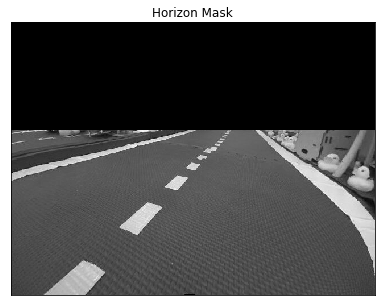

In [15]:
# TODO: Implement mask

xmax = 2
X = np.array([xmax, 0.0, 1.0])
x = Hinv.dot(X)
x = x/x[-1]

height = img.shape[1]
mask_ground = np.ones(img.shape, dtype=np.uint8)
mask_ground[0:int(np.floor(x[1])),:] = 0

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img*mask_ground,cmap = 'gray')
ax1.set_title('Horizon Mask'), ax1.set_xticks([]), ax1.set_yticks([]);

## Finding the Horizon

In Duckietown, the ground is planar and in other self-driving and robotics domains, it is often assumed that the ground is locally planar. We can exploit this as we search for lane markings by not searching above the horizon. In the world frame relative to which we estimated the homography (i.e., a reference frame with the origin centered between the drive wheels with the positive $x$-axis pointing forward and the positive $y$-axis to the left), the horizon corresponds to large $x$-coordinates. In Duckietown, we are only interested in the road a few meters in front of the Duckiebot.

### Example: Masking out the Horizon

Implement a mask that separates the ground plane from the horizon based on the homography (technically, $H^{-1}$).

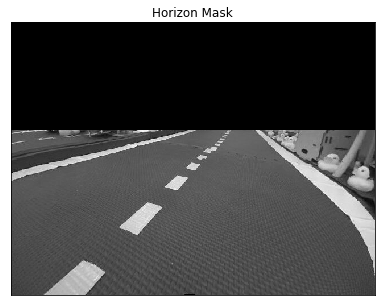

In [7]:
# TODO: Implement mask

xmax = 2
X = np.array([xmax, 0.0, 1.0])
x = Hinv.dot(X)
x = x/x[-1]

height = img.shape[1]
mask_ground = np.ones(img.shape, dtype=np.uint8)
mask_ground[0:int(np.floor(x[1])),:] = 0

fig = plt.figure(figsize = (30,20))
ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img*mask_ground,cmap = 'gray')
ax1.set_title('Horizon Mask'), ax1.set_xticks([]), ax1.set_yticks([]);

## Color-based Masking

Having identified a candidate set of edges, we can now try design a set of masks that isolate the edges associated with the dashed-yellow and solid-white lane markings.

Perhaps the most obvious thing to do is to create masks that filter out pixels whose color differs from that of the yellow and white lines. 

### Exercise: Color-based Masking

Following what we did in the Braitenberg exercise, we can select upper- and lower-bounds on the HSV values for the two lines. One option mentioned in the Braitenberg exercise is to use [this online color picker](https://pinetools.com/image-color-picker), which allows us to get the HSV values for particular pixels. 

**Note**: When we go to use these bounds, remember that OpenCV uses uses the convention that $\textrm{H} \in [0, 179]$, $\textrm{S} \in [0, 255]$, and $\textrm{V} \in [0, 255]$, while other tools may use different ranges (e.g., Gimp uses $\textrm{H} \in [0, 360]$, $\textrm{S} \in [0, 100]$, and $\textrm{V} \in [0, 100])$.

**Note**: While the HSV color space provides a better representation (e.g., compared to RGB) for color-based detection, the appearance of the yellow and white lane markings will change due to variations in illumination, shading, etc. for In order to improve the generalizability of these bounds, you are encouraged to also consider the `../images/visual_control/pic3_rect.png` image and define bounds that are appropriate for both.

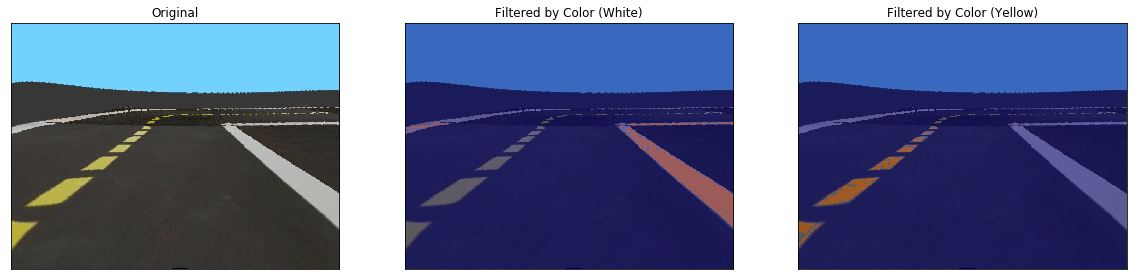

In [5]:
# Using the above tool, we can identify the bounds as follows
# Since OpenCV uses a Hue range of [0, 179], we need to divide the Hue values above by 2
# The following are for the real-world images captured at TTIC
white_lower_hsv = np.array([0/2, 3*255/100, 52*255/100])
white_upper_hsv = np.array([360/2, 26*255/100, 96*255/100])
yellow_lower_hsv = np.array([44/2, 47*255/100, 48*255/100])
yellow_upper_hsv = np.array([55/2, 100*255/100, 85*255/100])

# The following is for the simulator (based on the image referenced above)
white_lower_hsv = np.array([0/2, 0*255/100, 69*255/100])
white_upper_hsv = np.array([330/2, 4*255/100, 74*255/100])
yellow_lower_hsv = np.array([54/2, 30*255/100, 69*255/100])
yellow_upper_hsv = np.array([57/2, 70*255/100, 79*255/100])

mask_white_orig = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
mask_yellow_orig = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(imgrgb)
ax1.set_title('Original'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(imgrgb)
ax2.imshow(mask_white_orig, cmap='jet', alpha=0.5)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(imgrgb)
ax3.imshow(mask_yellow_orig, cmap='jet', alpha=0.5)
ax3.set_title('Filtered by Color (Yellow)'), ax3.set_xticks([]), ax3.set_yticks([]);

### Exercise: Image dilation

Conservative values for the lower- and upper-bounds used for HSV filtering, will result in many false negatives (i.e., missing pixels that actually correspond to the dashed-yellow or solid-white lane markings, but that fall outside the bounds). We can increase the range in order to capture many of these pixels, but that will generally come at the expense of false positives.

One way to deal with this is to use more conservative values for the lower- and upper-bounds, but to then grow the resulting masks to capture nearby pixels that were not detected. We can do this through image *dilation*, a morphological process that expands non-zero regions in a binary image. In this case, the binary images are the HSV-based masks identified above and the non-zero regions are pixels identified as being yellow or white.

In this exercise, you will experiment with the size of the dilation kernel. As you do, remember that we will be masking out the horizon, so don't worry too much if dilation results in false positives in the upper part of the image.

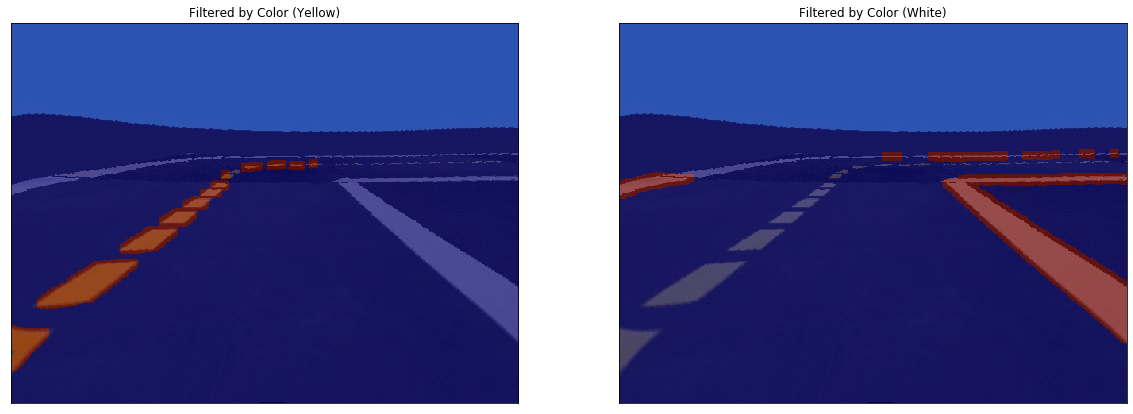

In [6]:
# TODO: Experiment with the size of the dilation kernel to see its effect on the masks
dilation_kernel = np.ones((11, 11), np.uint8)

mask_yellow = cv2.dilate(mask_yellow_orig, dilation_kernel, iterations=1)
mask_white = cv2.dilate(mask_white_orig, dilation_kernel, iterations=1)

fig = plt.figure(figsize = (20,10))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(imgrgb)
ax1.imshow(mask_yellow, cmap='jet', alpha=0.6)
ax1.set_title('Filtered by Color (Yellow)'), ax1.set_xticks([]), ax1.set_yticks([]);
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(imgrgb)
ax2.imshow(mask_white, cmap='jet', alpha=0.6)
ax2.set_title('Filtered by Color (White)'), ax2.set_xticks([]), ax2.set_yticks([]);

## Masking

Let's now combine these masks to best isolate the features that we care about.

In [7]:
mask_left_edge = mask_ground * mask_yellow
mask_right_edge = mask_ground * mask_white

## Hough Transform

At this point, we have refined the candidate set of edges corresponding to the left and right lane markings. The next step in our approach is to find a set of line segments that best fit these detections. This is problem is challenging since there will most often be multiple line segments formed by the edges and these line segments will not be continuous due to missed edge detections. 



An effective approach to this problem is to use the *Hough transform*, which involves a voting strategy whereby points vote on their corresponding lines. The lines receiving the most votes are identified as best fitting the given set of points.

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/hough-transform-line-parameterization.png", width=300px>
  <figcaption>Lines are parameterized in terms of the distance $\rho$ between the origin and the closest point on the line and the angle $\theta$ to this point.</figcaption>
  </div>
</figure>

The Hough transform represents lines as

$$
\rho = x \cos \theta + y \sin \theta
$$

where $\rho$ is the distance from the origin to the closest point on the line and $\theta$ is the orientation of the line between this point and the origin. The Hough transform discretizes the space of distances $[0 \; \rho_\textrm{max}]$ for some user-selected $\rho_\textrm{max}$ and angles $[-\pi \; \pi]$. The algorithm builds an *accumulator* matrix $A$,  where $A(i,j)$ represents the number of points that vote for the line parameterized by $(\rho_i, \theta_j)$. For each point $(x_k, y_k)$, the algorithm loops over the set of angles and adds increments the the bin $A(i,j)$ consistent with $\rho = x_k \cos \theta_i + y_k \theta_j$ (i.e., $\rho_{i} \leq \rho < \rho_{i+1}$) by one, representing a vote for that line. In our case, where we are searching for lines that best fit edges, these points correspond to pixels identified by the Canny edge detector.

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/hough-transform-example.png", width=800px>
  <figcaption>The Hough transform considers the set of lines consistent with each point in the scene. In this case, the points support a line with $\theta = 60$ degrees and $\rho \approx 407$. (Courtesy: Wikipedia)</figcaption>
  </div>
</figure>

The figure above visualizes this strategy for a set of three points, where each point votes for the $(\rho_i, \theta_j)$ values that correspond to lines that pass through the point. The result is the line with $\theta = 60$ degrees and $\rho \approx 407$ receiving the most votes.

<figure>
  <div style="text-align:center;">
  <img src="../images/visual_control/hough-transform-accumulator.png", width=400px>
  <figcaption>A visualization of the accumulator matrix for a set of candidate distances $\rho$ and orientations $\theta$. Darker pixels denote $(\rho_i, \theta_j)$ values with few votes, while whte pixels represent $(\rho_i, \theta_j)$ values with a large number of votes.</figcaption>
  </div>
</figure>

The resulting accumulator matrix will have large entries for $(\rho_i, \theta_j)$-parameterized lines that are consistent with many points as visualized above. The next step is to identify these peaks, which we can do using a threshold on the minimum number of votes necessary for a line to be considered valid. This will often result in the identification of multiple lines, which we would expect in the context of edges detected in images. Many implementations convert each of these lines into a line segment based upon the set of points that are consistent with (i.e., that voted for) the line.

There are variations on the Hough transform that make the search more sophisticated. Among them, the one that we use below allows you to set an upper-bound on how far apart points can be while still considering to be part of the same line, as well as setting a lower-bound on the length of each line segment.

### Example: Hough Transform

In the following example, you will experiment with different parameter settings for the OpenCV implementation of the hough transform, which include
* `hough_threshold`: The minimum number of votes necessary for a line segment to be considered valid;
* `hough_min_line_length`: The minimum length of a line segment in order to be considered valid;
* `hough_max_line_gap`: The maximum spacing between points that are considered part of the same line segment;
* `hough_rho`: The resolution at which we discretize the space of distances $\rho$;
* `hough_theta`: The resolution at which we discretize the angles $\theta$.

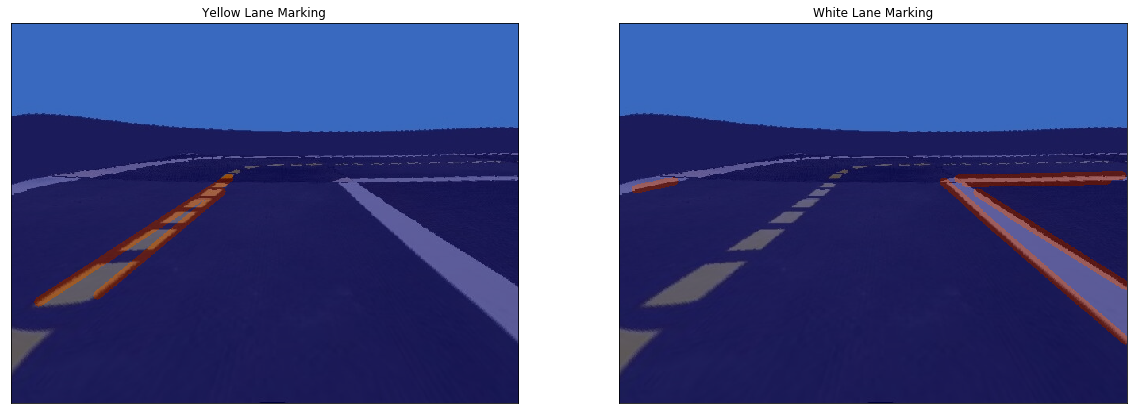

In [8]:
# TODO: Experiment with the Hough transform parameters for the left and right lane markings
hough_threshold_left = 50
hough_min_line_length_left = 10
hough_max_line_gap_left = 50
hough_rho_left = 1
hough_theta_left = 1*np.pi/180

# Parameters for white line detection
hough_threshold_right = 50 #100
hough_min_line_length_right = 2 #10
hough_max_line_gap_right = 15
hough_rho_right = 1
hough_theta_right = 1 * np.pi/180

lines_left = cv2.HoughLinesP(edges * mask_left_edge,
                        rho=hough_rho_left,
                        theta=hough_theta_left,
                        threshold=hough_threshold_left,
                        minLineLength=hough_min_line_length_left,
                        maxLineGap=hough_max_line_gap_left)




lines_right = cv2.HoughLinesP(edges * mask_right_edge,
                        rho=hough_rho_right,
                        theta=hough_theta_right,
                        threshold=hough_threshold_right,
                        minLineLength=hough_min_line_length_right,
                        maxLineGap=hough_max_line_gap_right)


lines_image_left = np.zeros_like(img)
if lines_left is not None:
    for line in lines_left:
        [[x1, y1, x2, y2]] = line
        cv2.line(lines_image_left, (x1, y1), (x2, y2), (255, 0, 0), 10)
        
lines_image_right = np.zeros_like(img)
if lines_right is not None:
    for line in lines_right:
        [[x1, y1, x2, y2]] = line
        cv2.line(lines_image_right, (x1, y1), (x2, y2), (255, 0, 0), 10)


# Visualize the resulting edges
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax1.imshow(lines_image_left, cmap='jet', alpha=0.5)
ax1.set_title('Yellow Lane Marking'), ax1.set_xticks([]), ax1.set_yticks([])
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax2.imshow(lines_image_right, cmap='jet', alpha=0.5)
ax2.set_title('White Lane Marking'), ax2.set_xticks([]), ax2.set_yticks([]);

## Ground Projection

Unlike the previous exercise, where we only reasoned over image-space detections, it will be useful to consider these line segments when expressed in the world (ground) reference frame. We can transform coordinates expressed in the image plane to the ground plane using the camera's $3 \times 3$ homography matrix. Here, we will use the homography defined above, but in practice (e.g., when running in simulation or on your own Duckiebot), we would use the homography for the camera that acquired the images.

$$
\mathbf{X}_i = H \mathbf{x}_i
$$

where $\mathbf{x}_i$ is the homogeneous coordinate of a point in the image plane and $\mathbf{X}_i$ is the homogeneous coordinate of its corresponding projection in the ground frame.

### Example: Image to Ground Projection

In this example, you are asked to implement a `project_image_to_ground` function that takes as input the homography matrix H and a point in the image, and outputs the corresponding coordinates in the world frame. We will then

In [9]:
def project_image_to_ground(H, x):
    """
        Args:
            H: The 3x3 image-to-ground plane homography (numpy.ndarray)
            x: An array of non-homogeneous image coordinates, one per column (numpy.ndarray)
        Returns:
            X: An array of non-homogeneous coordinates in the world (ground) frame, one per column (numpy.ndarray)
    """
    
    if x.shape[0] == 2:
        if x.ndim == 1:
            x = np.append(x, 1)
        else:
            x = np.vstack((x, np.ones((1, x.shape[1]))))
    
    X = H.dot(x)
    X = X/X[2,None]
    
    return X[0:2,]

The following code uses your `project_image_to_ground` function to render the line segments from the Hough transform. You can use this to validate your implementation. Remember, the origin of the ground frame is located at the mid-point of the Duckiebot's drive wheels (and on the ground, of course), with the $x$-axis pointing forward and the $y$-axis pointing to the left.

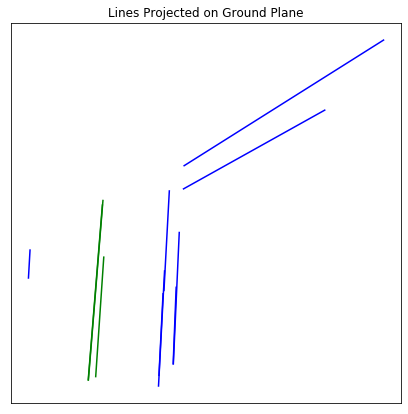

In [10]:
def render_ground_projections (lines_left, lines_right):
    """
        Renders the ground-plane projection of the left and right line detections
     
        Args:
            lines_left:  An n x 4 array of candidate lines for the right lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
    """

    fig = plt.figure(figsize = (7,7))
    ax1 = fig.add_subplot(1,1,1)
    ax1.set_title('Lines Projected on Ground Plane'), ax1.set_xticks([]), ax1.set_yticks([]);
    if lines_left is not None:
        # Visualize the edges projected on to the ground plane
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            # The ground reference frame has positive X up and positivy Y left
            # So, for the sake of plotting we treat X as Y, and Y as -X
            ax1.plot(-Y, X, 'g-')

    if lines_right is not None:
        # Visualize the edges projeted on to the ground plane
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            # The ground reference frame has positive X up and positivy Y left
            # So, for the sake of plotting we treat X as Y, and Y as -X
            ax1.plot(-Y, X, 'b-')
            
render_ground_projections(lines_left, lines_right)

Having detected a candidate set of lines that correspond to the left (dashed-yellow) and right (solid-white) lane markings, we can now consider their orientation in the ground frame as an indication of the Duckiebot's orientation relative to its lane.

### Example: Line Orientations in the Ground Plane

In this example, you will explore the orientations of the detected lines in the ground frame. We provide the routines for computing the orientations of any detected line segments.

**Note**: The function below calls the `project_image_to_ground` function that you defined above. If you run into problems with your implementation of this function, consider looking at how it is implemented in the solutions.

In [184]:
def get_lane_marking_orientations(lines_left, lines_right):
    """
        Computes the orientation of any detected lines in the ground frame

        Args:
            lines_left:  An n x 4 array of candidate lines for the right lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
                         
        Returns:
            theta_left:  An n-element array of the orientations of each candidate line 
                         for the left lane markings
            theta_right  An n-element array of the orientations of each candidate line 
                         for the right lane markings
    """
    
    thetas_left = np.array([])
    thetas_right = np.array([])
    if lines_left is not None:
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)
            
            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_left = np.append(thetas_left, theta)

    if lines_right is not None:
        # Visualize the edges projeted on to the ground plane
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)

            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_right = np.append(thetas_right, theta)
            
    return (thetas_left, thetas_right)

(thetas_left, thetas_right) = get_lane_marking_orientations(lines_left, lines_right)

Depending on the number and nature of the line segments that you identified earlier using the Hough transform, there may be a lot of variance in the orientations. We can see this by looking at the histograms for the left and right orientations.

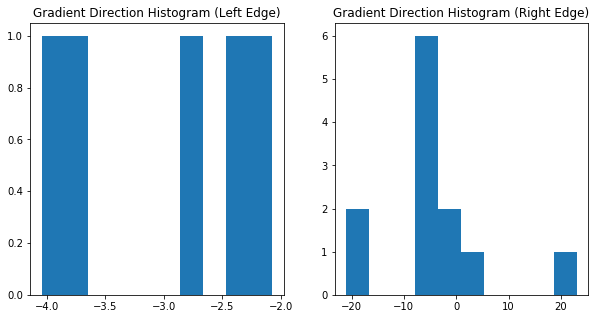

In [185]:
# Now, let's apply the mask to our gradient directions
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.hist(thetas_left*180/np.pi, bins=10)
ax1.set_title('Gradient Direction Histogram (Left Edge)')
ax2 = fig.add_subplot(1,2,2)
ax2.hist(thetas_right*180/np.pi, bins=10)
ax2.set_title('Gradient Direction Histogram (Right Edge)');

If one of the histograms is too spread out and there isn't a clear or valid mode (i.e., there is no dominant peak or there is a dominant peak, but it corresponds to noise and is wrong), we will want to revisit the parameters that we used for the Hough transform to better isolate lines corresponding to the lane markings.

Depending on the number of bins that we used to generate the histogram, we also may see histograms that are peaked with a large number of lines having similar orientations. This can occur when there are other edges in the image that share the same orientation, namely the solid-white lane marking to the left.

## Estimating the Duckiebot's Lane-relative Orientation

Assuming that we have a valid set of line segments corresponding to the lane markings, we can use their orientations to estimate the Duckiebot's orientation relative to the lane. There are different ways that we can formulate this problem depending on the amount of outliers.

### Example: Using the Mode of the Distribution

One approach that we can adopt is to look at the mode of the distribution over the orientations of all the candidate line segments. This has the advantage that outliers don't affect the resulting estimate, unless, of course, they are the mode.

In [186]:
thetas = np.append(thetas_left, thetas_right)

# Determine the orientation of the left and right gradients as the mode of each histogram
(hist_thetas, bins_thetas) = np.histogram(thetas, bins=30)

idx = hist_thetas.argmax()
theta_argmax = (bins_thetas[idx] + bins_thetas[idx+1])/2

print('Mode: %.2f degrees' %(theta_argmax * 180/np.pi))

Mode: -5.63 degrees


### Example: Using the Mean of the Distribution

If the distribution over the orientations of the line segments is spread out, as might be the case for a curve, we can consider taking the mean of the set of orientations (including both the left and right candidate lane markings). A drawback of this approach is that any erroneous line segments will affect the resulting estimate.

In [187]:
thetas = np.append(thetas_left, thetas_right)

theta_mean = np.mean(thetas)

print("Mean: %.2f degrees" %(theta_mean * 180/np.pi))

Mean: -4.27 degrees


# 💻 🚙 Write the PID lane-following function

Now, we can consider combining the ability to estimate the orientation of the robot relative to its lane with a feedback controller that steers the vehicle (i.e., changes its angular rate) in order to maintain a desired orientation relative to the lane. In this case, an orientation of zero degrees. 

Here, we ask you to implement the following two functions:

1. A function that takes as input the image from the Duckiebot's forward-facing camera and outputs an estimate of the robot's orientation relative to the lane.

2. A PID controller that actuates the angular rate of the Duckiebot in order to maintain a dersired orientation relative to the lane.

## PID Heading Controller

We will use a PID controller to control the Duckiebot's heading relative to its lane.

⚠️ ***WARNING:***
- DO NOT CHANGE THE NAME OF THE FOLLOWING FUNCTION
- DO NOT CHANGE THE ARGUMENTS OF THE FUNCTION
- DO NOT CREATE NEW CODE CELLS, THEY WILL NOT BE CONSIDERED

In [5]:
# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your PIDController function! 
# DO NOT CHANGE THE NAME OF THIS FUNCTION, INPUTS OR OUTPUTS, OR THINGS WILL BREAK

import numpy as np

# TODO: write your PID function for heading control!

def PIDController(v_0, theta_ref, theta_hat, prev_e, prev_int, delta_t):
    """
    Args:
        v_0 (:double:) linear Duckiebot speed (given).
        theta_ref (:double:) reference heading pose
        theta_hat (:double:) the current estiamted theta.
        prev_e (:double:) tracking error at previous iteration.
        prev_int (:double:) previous integral error term.
        delta_t (:double:) time interval since last call.
    returns:
        v_0 (:double:) linear velocity of the Duckiebot 
        omega (:double:) angular velocity of the Duckiebot
        e (:double:) current tracking error (automatically becomes prev_e_y at next iteration).
        e_int (:double:) current integral error (automatically becomes prev_int_y at next iteration).
    """
    
    # TODO: these are random values, you have to implement your own PID controller in here
    omega = np.random.uniform(-8.0, 8.0)
    e = np.random.random()
    e_int = np.random.random()
    
    # SOLUTION
    # Tracking error
    e = theta_ref - theta_hat

    # integral of the error
    e_int = prev_int + e*delta_t

    # anti-windup - preventing the integral error from growing too much
    e_int = max(min(e_int,2),-2)

    # derivative of the error
    e_der = (e - prev_e)/delta_t

    # controller coefficients
    Kp = 5
    Ki = 0.2
    Kd = 0.1

    # PID controller for omega
    omega = Kp*e + Ki*e_int + Kd*e_der
    
    #print(f"\n\nDelta time : {delta_t} \nE : {np.rad2deg(e)} \nE int : {e_int} \nPrev e : {prev_e} \nU : {u} \nTheta hat: {np.rad2deg(theta_hat)} \n")
        
    return [v_0, omega], e, e_int

## Estimating the Robot's Lane-relative Orientation  

Based on what we have learned above, write a function that takes as input the image from the Duckiebot's camera (in the BGR color space) and outputs an estimate of the robot's orienatation relative to the lane, along with the line segments associated with the left and right lane markings *in the ground reference frame* (i.e., the reference frame centered between the Duckiebot's drive wheels with the positive $x$-axis pointing forward and the positive $y$-axis pointing left. The orientation will serve as the estimate of the robot's lane-relative heading that is used by the PID controller, while we will use the line segments for visualization.

You are welcome to add additional functions in the cell below that you want to call from your `estimate_lane_relative_headings` function (e.g., the `project_image_to_ground` function that you created above, or the `get_lane_marking_orientations`.

⚠️ ***WARNING:***
- DO NOT CHANGE THE NAME OF THE FOLLOWING FUNCTION
- DO NOT CHANGE THE ARGUMENTS OF THE FUNCTION
- DO NOT CREATE NEW CODE CELLS, THEY WILL NOT BE CONSIDERED

In [1]:
# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your DeltaPhi function! 
# DO NOT CHANGE THE NAME OF THIS FUNCTION, INPUTS OR OUTPUTS, OR THINGS WILL BREAK

import numpy as np
import cv2

#TODO: write a correct function

def estimate_lane_relative_heading(H, image):
    """
        Args:
            H: The 3x3 image-to-ground plane homography (numpy.ndarray)
            image: An image from the robot's camera in the BGR color space (numpy.ndarray)
        Return:
            theta_hat: An estimate of the robot's heading (radians) relative to the lane (float)
            lm_left_ground:  An n x 4 array of candidate lines for the right lane markings (numpy.ndarray)
                             Each row [x0, y0, x1, y1] specifies the line-segment coordinate in the ground frame
            lm_right_ground: An m x 4 array of candidate lines for the left lane markings (numpy.ndarray)
                             Each row [x0, y0, x1, y1] specifies the line-segment coordinate in the ground frame
    """
    
    # TODO: these are random values, you have to implement your own solution in here
    theta_hat = np.random.random()
    lm_left_ground = np.empty((0, 4), float)
    lm_right_ground = np.empty((0, 4), float)
    
    # SOLUTION
    
    imghsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    Hinv = np.linalg.inv(H)
    
    # Masking the horizon
    xmax = 2
    X = np.array([xmax, 0.0, 1.0])
    x = Hinv.dot(X)
    x = x/x[-1]

    height, width, _ = image.shape
    mask_ground = np.ones((height, width), dtype=np.uint8)
    mask_ground[0:int(np.floor(x[1])),:] = 0
    
    
    # Gaussian smoothing
    sigma = 2
    img_gaussian_filter = cv2.GaussianBlur(image,(0,0), sigma)

    # Canny edge detection
    canny_lower_threshold = 80
    canny_upper_threshold = 200
    canny_kernel_size = 3;

    edges = cv2.Canny(img_gaussian_filter, canny_lower_threshold, canny_upper_threshold, canny_kernel_size)

    
    # Color-based masking
    # Using the above tool, we can identify the bounds as follows
    # Since OpenCV uses a Hue range of [0, 179], we need to divide the Hue values above by 2
    white_lower_hsv = np.array([0/2, 3*255/100, 52*255/100])
    white_upper_hsv = np.array([360/2, 26*255/100, 96*255/100])
    yellow_lower_hsv = np.array([44/2, 47*255/100, 48*255/100])
    yellow_upper_hsv = np.array([55/2, 100*255/100, 85*255/100])

    mask_white_orig = cv2.inRange(imghsv, white_lower_hsv, white_upper_hsv)
    mask_yellow_orig = cv2.inRange(imghsv, yellow_lower_hsv, yellow_upper_hsv)

    # Color dilation
    dilation_kernel = np.ones((11, 11), np.uint8)

    mask_yellow = cv2.dilate(mask_yellow_orig, dilation_kernel, iterations=1)
    mask_white = cv2.dilate(mask_white_orig, dilation_kernel, iterations=1)
    
    # Masking
    mask_left_edge = mask_ground * mask_yellow
    mask_right_edge = mask_ground * mask_white
  
    # Hough Transform
    # Parameters for left line detection
    hough_threshold_left = 50
    hough_min_line_length_left = 10
    hough_max_line_gap_left = 50
    hough_rho_left = 1
    hough_theta_left = 1*np.pi/180

    # Parameters for white line detection
    hough_threshold_right = 50 #100
    hough_min_line_length_right = 2 #10
    hough_max_line_gap_right = 15
    hough_rho_right = 1
    hough_theta_right = 1 * np.pi/180

    lines_left = np.array([])
    lines_right = np.array([])
    lines_left = cv2.HoughLinesP(edges * mask_left_edge,
                            rho=hough_rho_left,
                            theta=hough_theta_left,
                            threshold=hough_threshold_left,
                            minLineLength=hough_min_line_length_left,
                            maxLineGap=hough_max_line_gap_left)




    lines_right = cv2.HoughLinesP(edges * mask_right_edge,
                            rho=hough_rho_right,
                            theta=hough_theta_right,
                            threshold=hough_threshold_right,
                            minLineLength=hough_min_line_length_right,
                            maxLineGap=hough_max_line_gap_right)
    
    (thetas_left, thetas_right) = get_lane_marking_orientations(H, lines_left, lines_right)
    thetas = np.append(thetas_left, thetas_right)

    # Determine the orientation of the left and right gradients as the mode of each histogram
    (hist_thetas, bins_thetas) = np.histogram(thetas, bins=30)

    idx = hist_thetas.argmax()
    theta_argmax = (bins_thetas[idx] + bins_thetas[idx+1])/2
    theta_mean = np.mean(thetas)

    theta_hat = theta_argmax
    
    
    # Project these to the ground frame
    lm_left_ground = np.empty((0, 4), float)
    lm_right_ground = np.empty((0, 4), float)
    if lines_left is not None:
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1).flatten()
            XY2 = project_image_to_ground(H, xy2).flatten()

            lm_left_ground = np.append(lm_left_ground, np.array([[XY1[0], XY1[1], XY2[0], XY2[1]]]), axis=0)

    if lines_right is not None:
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1).flatten()
            XY2 = project_image_to_ground(H, xy2).flatten()
            
            lm_right_ground = np.append(lm_right_ground, np.array([[XY1[0], XY1[1], XY2[0], XY2[1]]]), axis=0)

    #print(lm_right_ground)
    return (theta_hat, lm_left_ground, lm_right_ground)



def project_image_to_ground(H, x):
    """
        Args:
            H: The 3x3 image-to-ground plane homography (numpy.ndarray)
            x: An array of non-homogeneous image coordinates, one per column (numpy.ndarray)
        Returns:
            X: An array of non-homogeneous coordinates in the world (ground) frame, one per column (numpy.ndarray)
    """
    
    if x.shape[0] == 2:
        if x.ndim == 1:
            x = np.append(x, 1)
        else:
            x = np.vstack((x, np.ones((1, x.shape[1]))))
    
    X = H.dot(x)
    X = X/X[2,None]
    
    return X[0:2,]



def get_lane_marking_orientations(H, lines_left, lines_right):
    """
        Computes the orientation of any detected lines in the ground frame

        Args:
            H:           The 3x3 image-to-ground plane homography (numpy.ndarray)
            lines_left:  An n x 4 array of candidate lines for the right lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
            lines_right: An m x 4 array of candidate lines for the left lane markings
                         Each row [x0, y0, x1, y1] specifies the line-segment coordinate
                         
        Returns:
            theta_left:  An n-element array of the orientations of each candidate line 
                         for the left lane markings
            theta_right  An n-element array of the orientations of each candidate line 
                         for the right lane markings
    """
    
    thetas_left = np.array([])
    thetas_right = np.array([])
    if lines_left is not None:
        for line in lines_left:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)
            
            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_left = np.append(thetas_left, theta)

    if lines_right is not None:
        for line in lines_right:
            [[x1, y1, x2, y2]] = line
            xy1 = np.array([[x1, y1]]).transpose()
            xy2 = np.array([[x2, y2]]).transpose()

            # Project to the ground frame
            XY1 = project_image_to_ground(H, xy1)
            XY2 = project_image_to_ground(H, xy2)

            X = np.array([XY1[0], XY2[0]])
            Y = np.array([XY1[1], XY2[1]])
            
            ind = np.argsort(X, axis=0)
            X = np.take_along_axis(X, ind, axis=0)
            Y = np.take_along_axis(Y, ind, axis=0)

            theta = np.arctan2(Y[1]-Y[0], X[1]-X[0])
            thetas_right = np.append(thetas_right, theta)
            
    return (thetas_left, thetas_right)

### Test the `estimate_lane_relative_heading` function

As we have seen, unit tests are valuable in confirming that a particular piece of code works as intended when provided with an expected input.

Let's see if the function you wrote above passes the following test!

First Image: theta_hat: -5.19 degrees
Second Image: theta_hat: 78.02 degrees


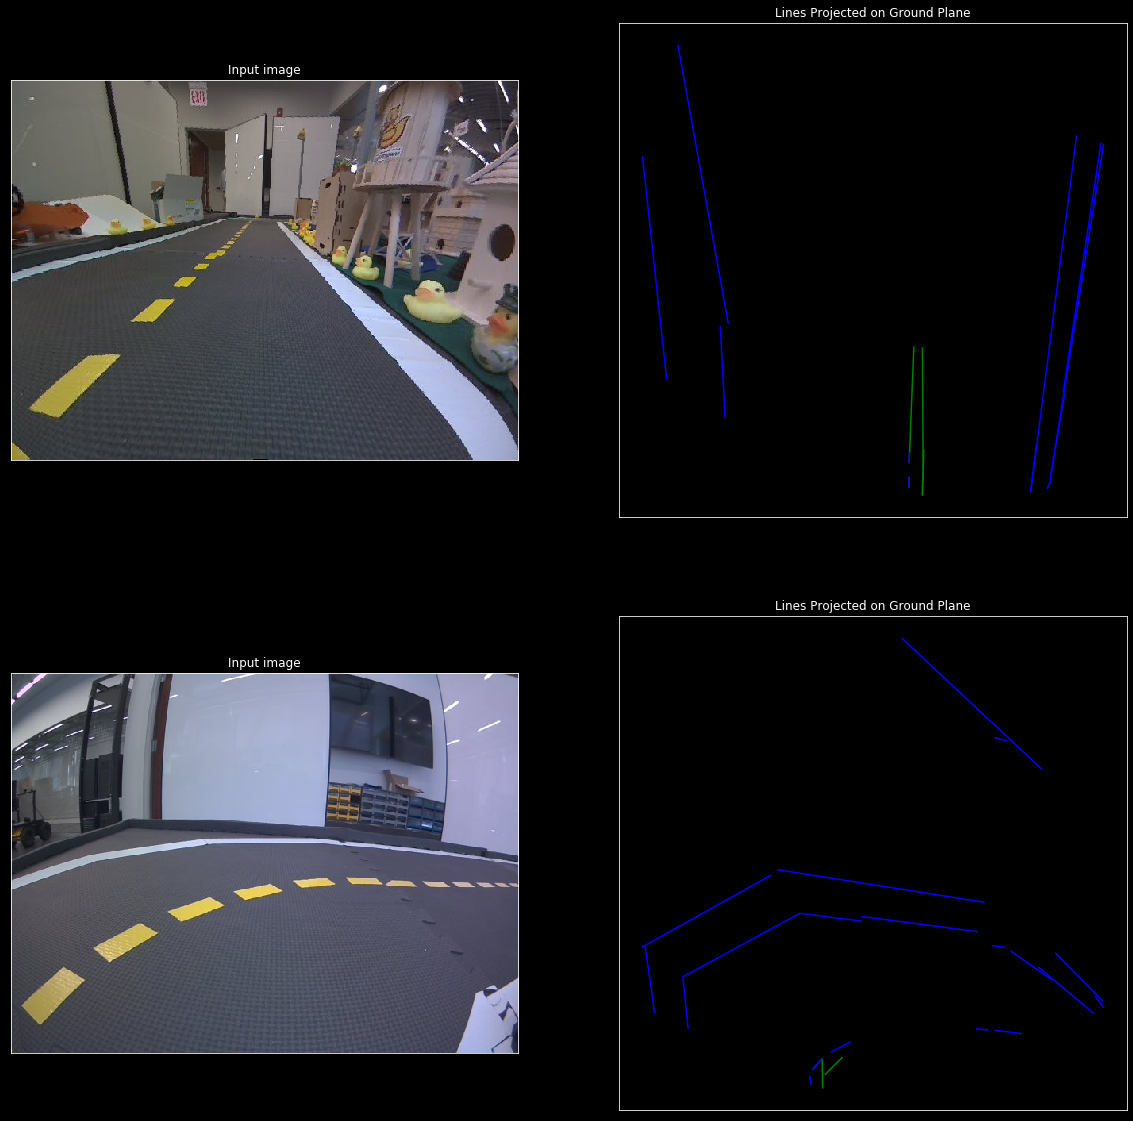

In [112]:
import sys
sys.path.append('../')
from unit_test import UnitTestELRH

# This function has hardcoded values (bad practice!) to test the LMOrientation function above. 
# The test will be successful if you get angles around 220 degrees (left edge) and 320 degrees (right edge)

UnitTestELRH(estimate_lane_relative_heading)

## 💻 Test your PID lane-following controller in the simulator

1. Open a terminal on your computer, and type 

       dts exercises build


2. Wait for the build to finish, then type:

       dts exercises test --sim


3. Open VNC on you browser and click on the `VLF - Visual Lane Following Exercise` icon on your desktop. You will see the following open (it might take ~30second or more, depending on the specifications of your computer):

    - A preconfigured RVIZ: to visualize your detections
    - A GUI with buttons labeled `Go` and `Stop`.

4. Place the Duckiebot in the center of its lane oriented in the direction of travel. Click `Go` in the GUI to activate your controller. The Duckiebot will start driving. You can click `Stop` at any time to stop the Duckiebot, and resume by clicking `Go`.

On the right side of the  RVIZ window, you should see an image showing the current view from the Duckiebot's camera.

On the terminal on your computer where you launched the activity, you will see some some initial instructions as well as some debugging information.

To test different solutions, change the `estimate_lane_relative_heading()` and `PIDController()` functions above. Each time you do, make sure to save this file (`Ctrl-S`) and then re-run the activity with `dts exercises test --sim`.

**Note**: Clicking on the icon will also bring up an LX terminal, which may print out an error message that stating "Tried to advertise a service that is already advertised in this node ...". You can ignore this error.

**Note** The lower- and upper-bounds for the color that you identified earlier may not be appropriate in the simulator. You many want to experiment with more conservative bounds.

## 🚙 Test your PID lane-following controller on your Duckiebot

1. Open a terminal on your computer, and type 

       dts exercises build


2. Wait for the build to finish, then type:

       dts exercises test -b ROBOTNAME


3. Follow the same instructions at point 3 for the simulation-based evaluation above.

**Note** The lower- and upper-bounds for the color that you identified earlier may not be appropriate for your Duckiebot. You many want to experiment with more conservative bounds or estimate the bounds based on images from your Duckiebot.

# Local evaluation and remote submission of your homework exercise

⚠️ You must submit this homework for evaluation if you are pursuing a verified track in the MOOC, by following the `Remote evalutation` instructions below.⚠️ 

## Local evaluation

If you want (this is not necessary) you can evaluate your submission locally before shipping it to the cloud. This will provide you access to detailed performacne metrics of your implementation on various episodes. Note that this will take a while to run (~30-60 minutes). 

1. Open a terminal, navigate to the exercise folder and run:


        dts challenges evaluate
        

2. The result of the simulation can be visualized in realtime at the link printed by the evaluator, for example:


3. The evaluation output is saved locally at the end of the evaluation process. 

## Remote submission (⚠️ This part is mandatory to submit your homework and receive an official evaluation ⚠️)

You can submit your agent for evaluation by: 

1. Opening a terminal on your computer, navigating to the exercise folder and running:


        dts challenges submit
        

2. The result of the submission can be visualize on the AIDO challenges website:

After some processing, you should see something like this:

```

~        ## Challenge mooc-viscontrol - MOOC - Visual Lane Following
~        
~                Track this submission at:
~        
~                    https://challenges.duckietown.org/v4/humans/submissions/SUBMISSION-NUMBER
~        
~                You can follow its fate using:
~        
~                    $ dts challenges follow --submission SUBMISSION-NUMBER
~        
~                You can speed up the evaluation using your own evaluator:
~        
~                    $ dts challenges evaluator --submission SUBMISSION-NUMBER
~        
~                For more information, see the manual at https://docs.duckietown.org/daffy/AIDO/out/
~        

```
